<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Ranidu-Gurusinghe/Model_Selection_and_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np


from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn. linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn. ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

Reading data

In [4]:
drive.mount('/content/drive')
# Load the preprocessed data
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx')

Mounted at /content/drive


In [5]:
data

,Date,Shift,Code,Department,Absenteeism Type,Status,Leave Type,Absent/Present,Reason,Joined Date,...,LeaveMonth,Encoded Reason,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeaveYear,NumOfLeaveDays,TookLeaveNextMonth,LeavesNextMonth,TargetCategory
0,2021-12-01,Shift A,AA369,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2015-09-11,...,12,11,1,0,0,2021,4,0,0,A
1,2021-12-01,Shift A,AA362,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2018-11-14,...,12,11,1,0,0,2021,4,1,24,C
2,2021-12-01,Shift A,AA359,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2019-10-09,...,12,11,1,0,0,2021,4,1,16,C
3,2021-12-01,Shift A,AA541,Team - MAT 4A - BD,Informed,Notified,1,MAT,Maternity,2020-10-02,...,12,11,1,0,0,2021,4,1,2,B
4,2021-12-01,Shift A,AA398,Team - MAT 3A - BD,Informed,Notified,1,MAT,Maternity,2008-02-29,...,12,11,1,0,0,2021,4,1,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40661,2023-12-22,Shift A,AA2212,Sewing Team - 145A - II - BD,Uninformed,Notified,1,Absent,Health Related,2018-06-12,...,12,9,1,1,0,2023,1,0,0,A
40662,2023-12-22,Shift A,AA723,Sewing Team - 109A - I - BD,Informed,Notified,1,Absent,Personal Reason,2017-11-15,...,12,15,1,0,0,2023,1,0,0,A
40663,2023-12-22,Shift A,AA1280,Sewing Team - 152A - I - BD,Informed,Notified,1,Absent,Personal Reason,2018-12-19,...,12,15,1,0,0,2023,1,0,0,A
40664,2023-12-22,Shift A,AA1964,Sewing Team - 135A - I - BD,Informed,Notified,1,Absent,Personal Reason,2021-07-02,...,12,15,1,0,0,2023,1,0,0,A


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40666 entries, 0 to 40665
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      40666 non-null  datetime64[ns]
 1   Shift                     40666 non-null  object        
 2   Code                      40666 non-null  object        
 3   Department                40666 non-null  object        
 4   Absenteeism Type          40659 non-null  object        
 5   Status                    40666 non-null  object        
 6   Leave Type                40666 non-null  int64         
 7   Absent/Present            40666 non-null  object        
 8   Reason                    40666 non-null  object        
 9   Joined Date               40666 non-null  datetime64[ns]
 10  DaysWorked                40666 non-null  int64         
 11  DayOfWeek                 40666 non-null  int64         
 12  Encoded Code      

##Preprocessing

In [7]:
def onehot_encode(df, column, prefix):
    df = df.copy()

    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)

    return df

In [8]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop ID columns
    df = df.drop('Date', axis=1)
    df = df.drop('Code', axis=1)
    df = df.drop('Shift', axis=1)
    df = df.drop('Department', axis=1)
    df = df.drop('Absenteeism Type', axis=1)
    df = df.drop('Status', axis=1)
    df = df.drop('Leave Type', axis=1)
    df = df.drop('Absent/Present', axis=1)
    df = df.drop('Reason', axis=1)
    df = df.drop('Joined Date', axis=1)
    df = df.drop('TargetCategory', axis=1)
    df = df.drop('TookLeaveNextMonth', axis=1)
    # One-hot encode the reason column
    df = onehot_encode(
        df,
        column='Encoded Reason',
        prefix='Reason'
    )

    # Split df into X and y
    y = df['LeavesNextMonth'].copy()
    X = df.drop('LeavesNextMonth', axis=1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
    # Scale X
    # scaler = StandardScaler()
    # scaler.fit(X_train)

    # X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    # X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

    return X_train, X_test, y_train, y_test

In [9]:
data = data[data['Date'] < '2023-12-01']
X_train, X_test, y_train, y_test = preprocess_inputs(data)

In [10]:
X_train

,DaysWorked,DayOfWeek,Encoded Code,LeaveMonth,Encoded Status,Encoded Absenteeism Type,Encoded Shift,LeaveYear,NumOfLeaveDays,Reason_0,...,Reason_9,Reason_10,Reason_11,Reason_12,Reason_13,Reason_14,Reason_15,Reason_16,Reason_17,Reason_18
37676,4928,1,1013,10,0,1,1,2023,4,0,...,0,0,0,0,0,1,0,0,0,0
19278,5778,4,1613,7,1,0,1,2022,1,0,...,0,0,0,0,0,0,1,0,0,0
31158,3438,3,234,5,1,0,1,2023,1,0,...,0,0,0,0,0,0,0,0,0,0
9052,849,5,663,3,1,0,1,2022,2,0,...,0,0,0,0,0,0,1,0,0,0
261,5068,4,3235,12,1,0,0,2021,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,1401,4,2463,3,0,1,0,2022,1,0,...,0,0,0,0,0,1,0,0,0,0
15377,268,3,2889,6,0,1,1,2022,1,0,...,0,0,0,0,0,0,0,0,0,0
17730,246,5,3527,6,1,0,1,2022,1,0,...,0,0,0,0,0,0,1,0,0,0
28030,482,1,2927,1,1,0,1,2023,1,0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
y_train

37676     0
19278     0
31158     2
9052     21
261       2
         ..
7763      2
15377     4
17730     0
28030     1
15725     0
Name: LeavesNextMonth, Length: 31795, dtype: int64

##Trainning

In [12]:
models = {
    "                     Linear Regression": LinearRegression(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor(),
    "                               XGBoost": XGBRegressor(),
    "                              LightGBM": LGBMRegressor(),
    "                              CatBoost": CatBoostRegressor(verbose=0)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
                   K-Nearest Neighbors trained.
                        Neural Network trained.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 31795, number of used features: 24
[LightGBM] [Info] Start training from score 4.685045
                              LightGBM trained.
                              CatBoost trained.


In [13]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test, y_test)))

                     Linear Regression R^2 Score: 0.26388
                   K-Nearest Neighbors R^2 Score: 0.47005
                        Neural Network R^2 Score: 0.23050
Support Vector Machine (Linear Kernel) R^2 Score: 0.05314
   Support Vector Machine (RBF Kernel) R^2 Score: -0.17882
                         Decision Tree R^2 Score: 0.27373
                         Random Forest R^2 Score: 0.60878
                     Gradient Boosting R^2 Score: 0.36794
                               XGBoost R^2 Score: 0.55913
                              LightGBM R^2 Score: 0.46938
                              CatBoost R^2 Score: 0.52079


From the R2 Scores we can determine that Random Forest performs the best among everything else.

##Making Random Forest Model

In [14]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=40,random_state=123)
rf_model.fit(X_train, y_train)

print("Random Forest Model R^2: {:.5f}".format(rf_model.score(X_test, y_test)))


Random Forest Model R^2: 0.61152


In [20]:
# Define a function to map predicted values to classes
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


def map_to_class(value):
    if value >= 2:
        return 'B'
    elif value >=0:
        return 'A'

# Make predictions on the test data
predictions_rf = rf_model.predict(X_test)
actual_classes = [map_to_class(value) for value in y_test]
# Map predicted values to classes
predicted_classes = [map_to_class(value) for value in predictions_rf]
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions_rf})
# Create a DataFrame to display actual and predicted values
results_classified_df = pd.DataFrame({'Actual': actual_classes, 'Predicted': predicted_classes})

# Calculate accuracy
accuracy = accuracy_score(actual_classes, predicted_classes)

print("Actual values and predictions:")
print(results_df)
print("\n\nAccuracy of Predicted Classes:", accuracy)

# Display the DataFrame
print(results_classified_df)


Actual values and predictions:
       Actual  Predicted
29176       0      1.188
15446       1      0.674
28579       0      0.754
27999       0      1.030
3763        0      2.045
...       ...        ...
36030      16     11.356
9579        0      7.276
6868        1     11.668
30861       7      3.786
849         1      5.258

[7949 rows x 2 columns]


Accuracy of Predicted Classes: 0.706000754811926
     Actual Predicted
0         A         A
1         A         A
2         A         A
3         A         A
4         A         B
...     ...       ...
7944      B         B
7945      A         B
7946      A         B
7947      B         B
7948      A         B

[7949 rows x 2 columns]


In [21]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(actual_classes, predicted_classes)

# Print the classification report
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           A       0.84      0.62      0.71      4687
           B       0.60      0.82      0.70      3262

    accuracy                           0.71      7949
   macro avg       0.72      0.72      0.71      7949
weighted avg       0.74      0.71      0.71      7949



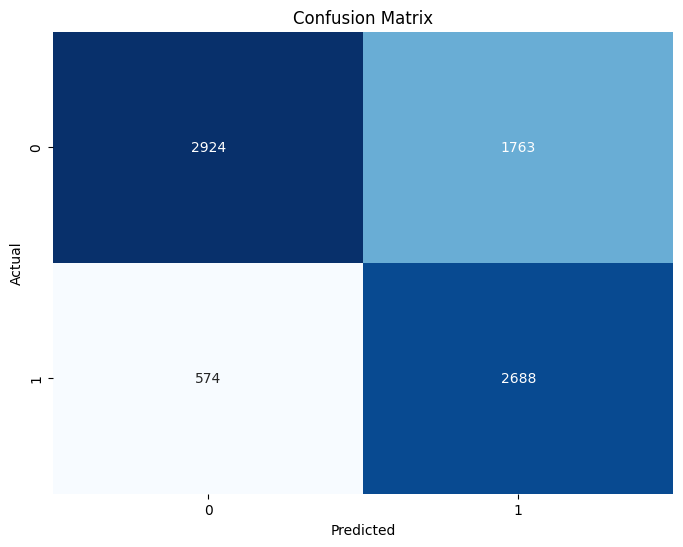

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(actual_classes, predicted_classes)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Fuzzy logic classifier

In [18]:
!pip install scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=f770fac2ff1f50321000aef87d5b96c3f075f718fbd0bb9f1d286a039e439bc4
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


Enter the output value from the random forest model (0-25): 10
The classification is: 16.460784313725494


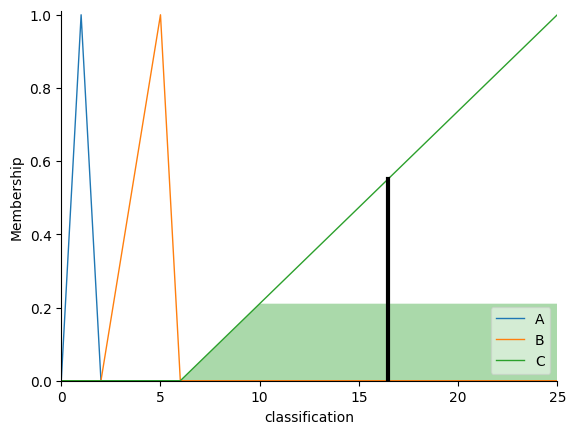

In [19]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define the universe variable
output = ctrl.Antecedent(np.arange(0, 26, 1), 'output')
classification = ctrl.Consequent(np.arange(0, 26, 1), 'classification')

# Define membership functions for output
output['A'] = fuzz.trimf(output.universe, [0, 1, 1])
output['B'] = fuzz.trimf(output.universe, [2, 3.5, 5])
output['C'] = fuzz.trimf(output.universe, [6, 25, 25])

# Define membership functions for classification
classification['A'] = fuzz.trimf(classification.universe, [0, 1, 1])
classification['B'] = fuzz.trimf(classification.universe, [2, 5, 5])
classification['C'] = fuzz.trimf(classification.universe, [6, 25, 25])

# Define rules
rule1 = ctrl.Rule(output['A'], classification['A'])
rule2 = ctrl.Rule(output['B'], classification['B'])
rule3 = ctrl.Rule(output['C'], classification['C'])

# Create and simulate control system
classify_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
classify = ctrl.ControlSystemSimulation(classify_ctrl)

# Input the output value from the random forest model
output_value = float(input("Enter the output value from the random forest model (0-25): "))

# Compute the classification
classify.input['output'] = output_value
classify.compute()

# Print the result
print("The classification is:", classify.output['classification'])
classification.view(sim=classify)
